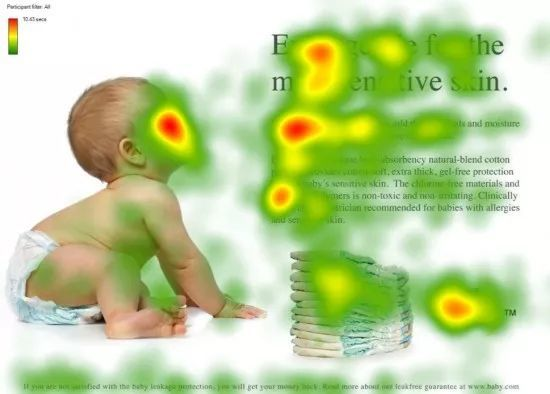

不随意线索/ 无意识
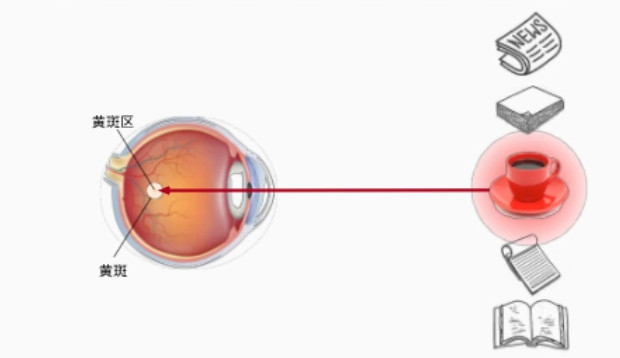
随意线索 / 刻意
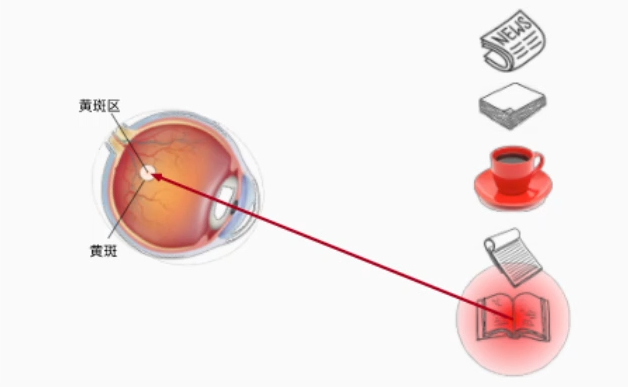

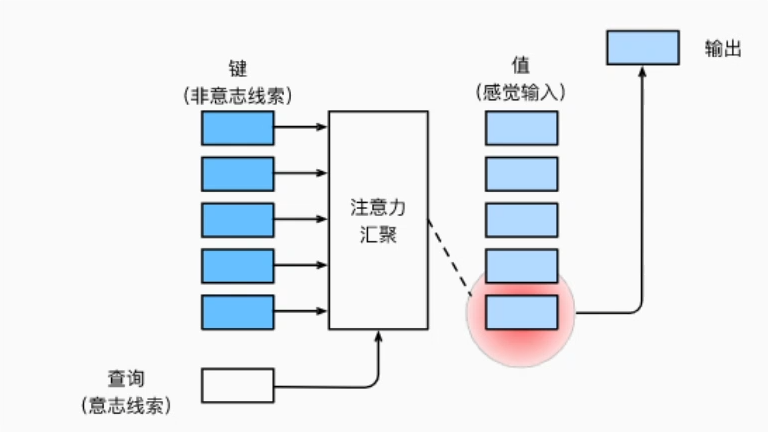

## 注意力汇聚-watson核回归
1. 生成数据集：
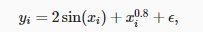
2. 平均汇聚:基于平均汇聚来计算所有训练样本输出值的平均值
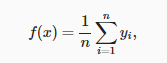
3. 非参数注意力汇聚
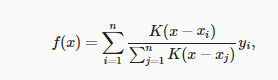
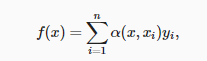
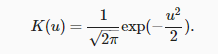
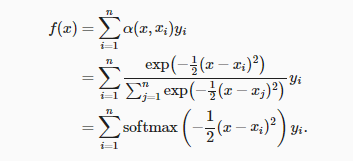
4. 带参数注意力汇聚
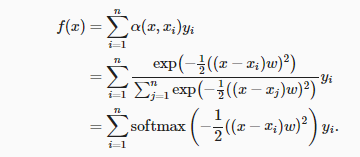

In [61]:
import torch
from torch import nn
import dltools

In [62]:
n_train = 50
x_train, _ = torch.sort(torch.rand(n_train) * 5)

In [63]:
x_train

tensor([0.0270, 0.0623, 0.1556, 0.2379, 0.2408, 0.2727, 0.3865, 0.5265, 0.5433,
        0.5777, 0.7351, 0.9708, 1.3539, 1.4611, 1.4643, 1.6696, 1.7967, 1.8314,
        1.8614, 1.8963, 1.9861, 2.4359, 2.5425, 2.6028, 2.6567, 2.7310, 2.7505,
        2.8984, 2.9640, 2.9966, 3.0385, 3.1908, 3.2215, 3.3714, 3.5055, 3.7183,
        3.8328, 3.9932, 4.2663, 4.2935, 4.3053, 4.4279, 4.4461, 4.5225, 4.6329,
        4.9359, 4.9383, 4.9450, 4.9459, 4.9781])

50


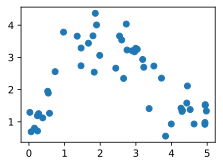

In [64]:
def f(x):
    return 2 * torch.sin(x) + x ** 0.8 

y_train = f(x_train) + torch.normal(0.0, 0.5, (n_train,))
x_test = torch.arange(0, 5, 0.1)
y_truth = f(x_test)
n_test = len(x_test)
print(n_test)
dltools.plt.scatter(x_train, y_train)

In [65]:
def plot_kernel_reg(y_hat):
    dltools.plot(x_test, [y_truth, y_hat], 'x', 'y', legend=['Truth', 'Pred'],
                xlim=[0, 5], ylim=[-1, 5])
    dltools.plt.plot(x_train, y_train, 'o', alpha=0.5)

In [66]:
torch.repeat_interleave(y_train.mean(), n_test)

tensor([2.2332, 2.2332, 2.2332, 2.2332, 2.2332, 2.2332, 2.2332, 2.2332, 2.2332,
        2.2332, 2.2332, 2.2332, 2.2332, 2.2332, 2.2332, 2.2332, 2.2332, 2.2332,
        2.2332, 2.2332, 2.2332, 2.2332, 2.2332, 2.2332, 2.2332, 2.2332, 2.2332,
        2.2332, 2.2332, 2.2332, 2.2332, 2.2332, 2.2332, 2.2332, 2.2332, 2.2332,
        2.2332, 2.2332, 2.2332, 2.2332, 2.2332, 2.2332, 2.2332, 2.2332, 2.2332,
        2.2332, 2.2332, 2.2332, 2.2332, 2.2332])

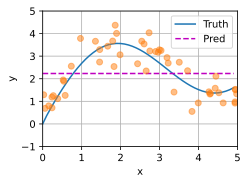

In [67]:
# 基于平均汇聚的效果
y_hat = torch.repeat_interleave(y_train.mean(), n_test)
plot_kernel_reg(y_hat)

In [68]:
X_repeat = x_test.repeat_interleave(n_train).reshape(-1, 50)
attention_weights = nn.functional.softmax(-(X_repeat - x_train) ** 2 / 2, dim=1)
y_hat = torch.matmul(attention_weights, y_train)

In [69]:
attention_weights.shape

torch.Size([50, 50])

In [70]:
attention_weights

tensor([[7.5394e-02, 7.5275e-02, 7.4514e-02,  ..., 3.6948e-07, 3.6778e-07,
         3.1358e-07],
        [7.0916e-02, 7.1055e-02, 7.0995e-02,  ..., 5.6831e-07, 5.6575e-07,
         4.8392e-07],
        [6.6431e-02, 6.6797e-02, 6.7367e-02,  ..., 8.7057e-07, 8.6672e-07,
         7.4376e-07],
        ...,
        [1.0729e-06, 1.2644e-06, 1.9406e-06,  ..., 5.7464e-02, 5.7451e-02,
         5.6969e-02],
        [7.0288e-07, 8.3128e-07, 1.2878e-06,  ..., 6.1560e-02, 6.1552e-02,
         6.1232e-02],
        [4.5836e-07, 5.4401e-07, 8.5065e-07,  ..., 6.5647e-02, 6.5644e-02,
         6.5513e-02]])

In [71]:
y_train.shape

torch.Size([50])

In [72]:
y_hat.shape

torch.Size([50])

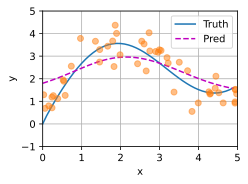

In [73]:
plot_kernel_reg(y_hat)

In [74]:
attention_weights.unsqueeze(0).unsqueeze(0).shape

torch.Size([1, 1, 50, 50])

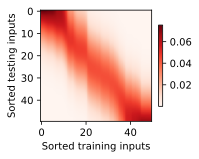

In [75]:
dltools.show_heatmaps(attention_weights.unsqueeze(0).unsqueeze(0), 
                     xlabel='Sorted training inputs', 
                     ylabel='Sorted testing inputs')

In [76]:
# 批量矩阵乘法. 
X = torch.ones((2, 1, 4))
Y = torch.ones((2, 4, 6))
torch.bmm(X, Y).shape

torch.Size([2, 1, 6])

In [77]:
weights = torch.ones((2, 10)) * 0.1
values = torch.arange(20.0).reshape((2, 10))
torch.bmm(weights.unsqueeze(1), values.unsqueeze(-1)).shape

torch.Size([2, 1, 1])

In [78]:
values.unsqueeze(-1).shape

torch.Size([2, 10, 1])

In [79]:
# 定义模型
class NWKernelRegression(nn.Module):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.w = nn.Parameter(torch.rand((1, ), requires_grad=True))
        
    def forward(self, queries, keys, values):
        # 规定一下queries的形状: (查询个数, '键值'对的个数)
        queries = queries.repeat_interleave(keys.shape[1]).reshape((-1, keys.shape[1]))
        self.attention_weights = nn.functional.softmax(-((queries - keys)* self.w) ** 2 / 2, dim=1)
        return torch.bmm(self.attention_weights.unsqueeze(1), values.unsqueeze(-1)).reshape(-1)

In [80]:
# 开始训练
X_tile = x_train.repeat((n_train, 1))
Y_tile = y_train.repeat((n_train, 1))

keys = X_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))
values = Y_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))

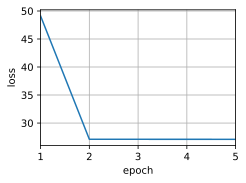

In [81]:
net = NWKernelRegression()
loss = nn.MSELoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=0.5)
animator = dltools.Animator(xlabel='epoch', ylabel='loss', xlim=[1, 5])

for epoch in range(5):
    trainer.zero_grad()
    l = loss(net(x_train, keys, values), y_train)
    l.sum().backward()
    trainer.step()
    print(f'epoch {epoch + 1}, loss {float(l.sum()):.6f}')
    animator.add(epoch + 1, float(l.sum()))

In [82]:
x_train

tensor([0.0270, 0.0623, 0.1556, 0.2379, 0.2408, 0.2727, 0.3865, 0.5265, 0.5433,
        0.5777, 0.7351, 0.9708, 1.3539, 1.4611, 1.4643, 1.6696, 1.7967, 1.8314,
        1.8614, 1.8963, 1.9861, 2.4359, 2.5425, 2.6028, 2.6567, 2.7310, 2.7505,
        2.8984, 2.9640, 2.9966, 3.0385, 3.1908, 3.2215, 3.3714, 3.5055, 3.7183,
        3.8328, 3.9932, 4.2663, 4.2935, 4.3053, 4.4279, 4.4461, 4.5225, 4.6329,
        4.9359, 4.9383, 4.9450, 4.9459, 4.9781])

In [83]:
torch.eye(n_train)

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])

In [84]:
(1 - torch.eye(n_train)).type(torch.bool)

tensor([[False,  True,  True,  ...,  True,  True,  True],
        [ True, False,  True,  ...,  True,  True,  True],
        [ True,  True, False,  ...,  True,  True,  True],
        ...,
        [ True,  True,  True,  ..., False,  True,  True],
        [ True,  True,  True,  ...,  True, False,  True],
        [ True,  True,  True,  ...,  True,  True, False]])

In [85]:
keys

tensor([[0.0623, 0.1556, 0.2379,  ..., 4.9450, 4.9459, 4.9781],
        [0.0270, 0.1556, 0.2379,  ..., 4.9450, 4.9459, 4.9781],
        [0.0270, 0.0623, 0.2379,  ..., 4.9450, 4.9459, 4.9781],
        ...,
        [0.0270, 0.0623, 0.1556,  ..., 4.9383, 4.9459, 4.9781],
        [0.0270, 0.0623, 0.1556,  ..., 4.9383, 4.9450, 4.9781],
        [0.0270, 0.0623, 0.1556,  ..., 4.9383, 4.9450, 4.9459]])

In [86]:
X_tile

tensor([[0.0270, 0.0623, 0.1556,  ..., 4.9450, 4.9459, 4.9781],
        [0.0270, 0.0623, 0.1556,  ..., 4.9450, 4.9459, 4.9781],
        [0.0270, 0.0623, 0.1556,  ..., 4.9450, 4.9459, 4.9781],
        ...,
        [0.0270, 0.0623, 0.1556,  ..., 4.9450, 4.9459, 4.9781],
        [0.0270, 0.0623, 0.1556,  ..., 4.9450, 4.9459, 4.9781],
        [0.0270, 0.0623, 0.1556,  ..., 4.9450, 4.9459, 4.9781]])

In [87]:
net.w

Parameter containing:
tensor([28.5171], requires_grad=True)

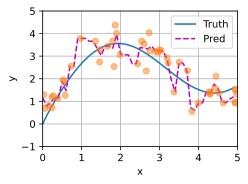

In [88]:
keys = x_train.repeat((n_test, 1))
values = y_train.repeat((n_test, 1))
y_hat = net(x_test, keys, values).unsqueeze(1).detach()
plot_kernel_reg(y_hat)

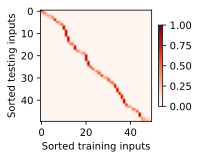

In [89]:
dltools.show_heatmaps(net.attention_weights.unsqueeze(0).unsqueeze(0), 
                     xlabel='Sorted training inputs', 
                     ylabel='Sorted testing inputs')